In [4]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/src/fashion')
IMAGE_DIR = Path('/mnt/nas/iMaterial')
ROOT_DIR = Path('/src')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [3]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [4]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
print(COCO_MODEL_PATH)

/src/weights/mask_rcnn_coco.h5


In [9]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 # a memory error occurs when IMAGES_PER_GPU is too high
    
#     BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [19]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [8]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.46%


In [9]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


ImageId  \
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg   

                                       EncodedPixels  Height  Width ClassId  \
0  6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676       6   
1  6323163 11 6328356 32 6333549 53 6338742 75 63...    5214   3676       0   
2  8521389 10 8526585 30 8531789 42 8537002 46 85...    5214   3676      28   
3  12903854 2 12909064 7 12914275 10 12919485 15 ...    5214   3676      31   
4  10837337 5 10842542 14 10847746 24 10852951 33...    5214   3676      32   

  CategoryId  
0          6  
1          0  
2         28  
3         31  
4         32

In [10]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()


Total images:  45625


EncodedPixels  \
ImageId                                                                                   
00000663ed1ff0c4e0132b9b9ac53f6e.jpg  [6068157 7 6073371 20 6078584 34 6083797 48 60...   
0000fe7c9191fba733c8a69cfaf962b7.jpg  [2201176 1 2203623 3 2206071 5 2208518 8 22109...   
0002ec21ddb8477e98b2cbb87ea2e269.jpg  [2673735 2 2676734 8 2679734 13 2682733 19 268...   
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg  [435 132 1002 132 1569 132 2136 132 2703 132 3...   
0004467156e47b0eb6de4aa6479cbd15.jpg  [132663 8 133396 25 134130 41 134868 53 135611...   

                                                             CategoryId  \
ImageId                                                                   
00000663ed1ff0c4e0132b9b9ac53f6e.jpg  [6, 0, 28, 31, 32, 32, 31, 29, 4]   
0000fe7c9191fba733c8a69cfaf962b7.jpg                            [33, 1]   
0002ec21ddb8477e98b2cbb87ea2e269.jpg                   [33, 10, 23, 23]   
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg                       [10, 33, 15]   
0004467156e47b0eb6de4aa6479cbd15.jpg               [10, 33, 31, 31, 15]   

                                      Height  Width  
ImageId                                              
00000663ed1ff0c4e0132b9b9ac53f6e.jpg    5214   3676  
0000fe7c9191fba733c8a69cfaf962b7.jpg    2448   2448  
0002ec21ddb8477e98b2cbb87ea2e269.jpg    3000   1997  
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg     567    400  
0004467156e47b0eb6de4aa6479cbd15.jpg     750    500

In [17]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [12]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(IMAGE_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('/mnt/nas/iMaterial/train/caff91fd71a6dda5c8694eade99e68dd.jpg', ['pants', 'pocket', 'neckline', 'sleeve', 'sleeve', 'top, t-shirt, sweatshirt'])


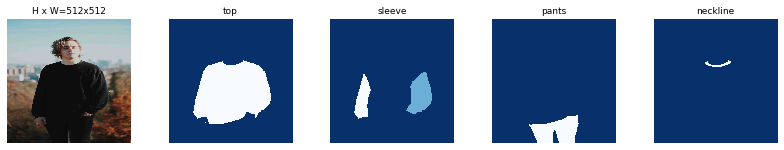

('/mnt/nas/iMaterial/train/4f3993844cf35ddcaf3d34b82f4e25b4.jpg', ['shoe', 'shoe', 'pants', 'sleeve', 'sleeve', 'scarf', 'top, t-shirt, sweatshirt', 'jacket', 'pocket'])


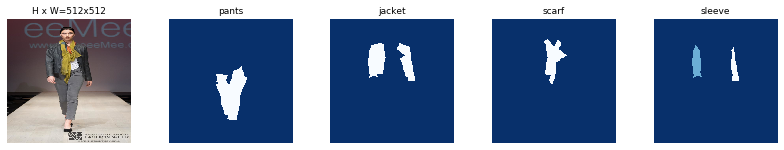

('/mnt/nas/iMaterial/train/dbf83d86421c8c97b658d0f046f9f216.jpg', ['top, t-shirt, sweatshirt', 'sleeve', 'sleeve', 'neckline'])


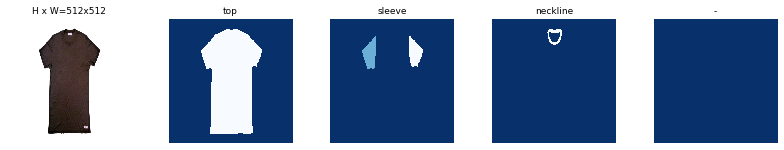

('/mnt/nas/iMaterial/train/786039c30bda71f524e00f2b18a726d9.jpg', ['shoe', 'shoe', 'belt', 'buckle', 'neckline', 'sleeve', 'pocket', 'sleeve', 'collar', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'pants'])


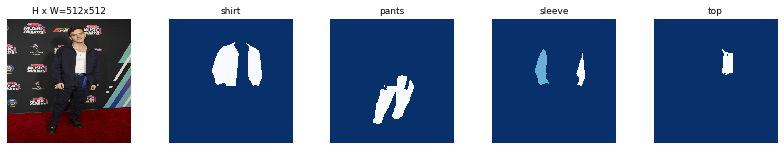

('/mnt/nas/iMaterial/train/caf171dec1ee18800d911a95f1478fe0.jpg', ['shoe', 'shoe', 'dress', 'neckline'])


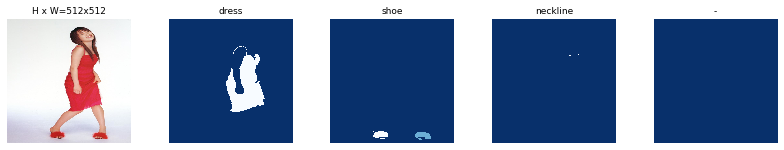

('/mnt/nas/iMaterial/train/bf7c48699c128a15548f9c56e060993a.jpg', ['sleeve', 'sleeve', 'coat', 'collar', 'jumpsuit', 'neckline', 'belt', 'shoe', 'shoe'])


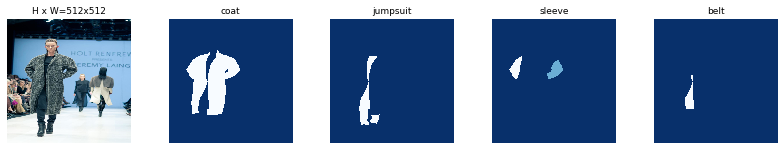

In [13]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [14]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [15]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
print(label_names,counts)

Total train images:  36500
Total train segments:  267004
['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'] [ 4929 13219  1193   874  6269   585  9939  2186  4063  2503 14989   743
   116  3903  2036  2727  1157  1116  2700  5519    73  3494  2075 37078
  5794  1114   121   977  8117  4779   697 47660 21759 27377  2675  6390
  2865  4058   394  1101   479   226  3960  1950   740   285]


<Figure size 864x216 with 0 Axes>

In [16]:
targetClasses = [{'class':label_names[x], 'count':counts[x]} for x in values]
targetClasses

[{'class': 'shirt, blouse', 'count': 4929},
 {'class': 'top, t-shirt, sweatshirt', 'count': 13219},
 {'class': 'sweater', 'count': 1193},
 {'class': 'cardigan', 'count': 874},
 {'class': 'jacket', 'count': 6269},
 {'class': 'vest', 'count': 585},
 {'class': 'pants', 'count': 9939},
 {'class': 'shorts', 'count': 2186},
 {'class': 'skirt', 'count': 4063},
 {'class': 'coat', 'count': 2503},
 {'class': 'dress', 'count': 14989},
 {'class': 'jumpsuit', 'count': 743},
 {'class': 'cape', 'count': 116},
 {'class': 'glasses', 'count': 3903},
 {'class': 'hat', 'count': 2036},
 {'class': 'headband, head covering, hair accessory', 'count': 2727},
 {'class': 'tie', 'count': 1157},
 {'class': 'glove', 'count': 1116},
 {'class': 'watch', 'count': 2700},
 {'class': 'belt', 'count': 5519},
 {'class': 'leg warmer', 'count': 73},
 {'class': 'tights, stockings', 'count': 3494},
 {'class': 'sock', 'count': 2075},
 {'class': 'shoe', 'count': 37078},
 {'class': 'bag, wallet', 'count': 5794},
 {'class': 'scarf

Total train images:  36500
Total train segments:  267004


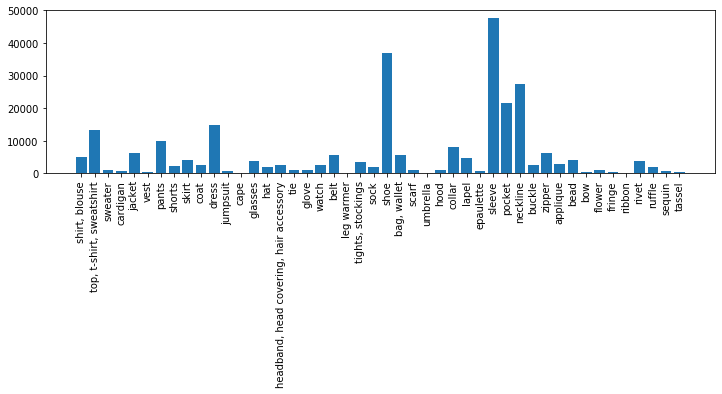

Total train images:  9125
Total validation segments:  66411


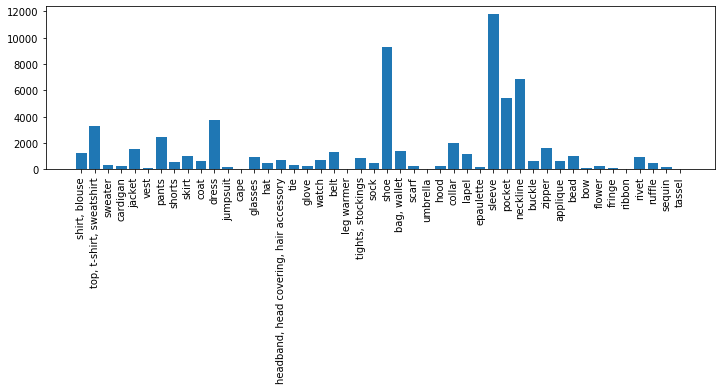

In [17]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

In [18]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [2, 6, 8, 10,100]

import warnings 
warnings.filterwarnings("ignore")


In [19]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [21]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR, # train heads with higher lr to speedup learning
            epochs=EPOCHS[4],
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0001

Checkpoint Path: /src/fashion20190724T1524/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

Epoch 1/100
1000/1000 [==============================] - 657s 657ms/step - loss: 3.1733 - rpn_class_loss: 0.1345 - rpn_bbox_loss: 1.0791 - mrcnn_class_loss: 0.6114 - mrcnn_bbox_loss: 0.6710 - mrcnn_mask_loss: 0.6773 - val_loss: 2.4922 - val_rpn_class_loss: 0.0945 - val_rpn_bbox_loss: 0.8907 - val_mrcnn_class_loss: 0.4426 - val_mrcnn_bbox_loss: 0.4834 - val_mrcnn_mask_loss: 0.5811
Epoch 2/100
1000/1000 [==============================] - 521s 521ms/step - loss: 2.4271 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.8768 - mrcnn_class_loss: 0.4826 - mrcnn_bbox_loss: 0.4403 - mrcnn_mask_loss: 0.5379 - val_loss: 2.2376 - val_rpn_class_loss: 0.0809 - val_rpn_bbox_loss: 0.7628 - val_mrcnn_class_loss: 0.4751 - val_mrcnn_bbox_loss: 0.4114 - val_mrcnn_mask_loss: 0.5074
Epoch 3/100
1000/1000 [==============================] - 523s 523ms/step - loss: 2.2122 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 0.8401 - mrcnn_class_loss: 0.4344 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.4738 - val_loss: 1.9366

1000/1000 [==============================] - 527s 527ms/step - loss: 1.4051 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.2929 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.2725 - val_loss: 1.3921 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 0.5602 - val_mrcnn_class_loss: 0.2923 - val_mrcnn_bbox_loss: 0.2252 - val_mrcnn_mask_loss: 0.2706
Epoch 44/100
1000/1000 [==============================] - 530s 530ms/step - loss: 1.4010 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.2707 - val_loss: 1.5615 - val_rpn_class_loss: 0.0543 - val_rpn_bbox_loss: 0.6506 - val_mrcnn_class_loss: 0.3299 - val_mrcnn_bbox_loss: 0.2440 - val_mrcnn_mask_loss: 0.2827
Epoch 45/100
1000/1000 [==============================] - 526s 526ms/step - loss: 1.4377 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2727 - val_loss: 1.3495 - val_rpn

1000/1000 [==============================] - 525s 525ms/step - loss: 1.3269 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.5529 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2548 - val_loss: 1.3191 - val_rpn_class_loss: 0.0378 - val_rpn_bbox_loss: 0.5572 - val_mrcnn_class_loss: 0.2679 - val_mrcnn_bbox_loss: 0.2090 - val_mrcnn_mask_loss: 0.2472
Epoch 86/100
1000/1000 [==============================] - 525s 525ms/step - loss: 1.3131 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2542 - val_loss: 1.4564 - val_rpn_class_loss: 0.0469 - val_rpn_bbox_loss: 0.6549 - val_mrcnn_class_loss: 0.2765 - val_mrcnn_bbox_loss: 0.2135 - val_mrcnn_mask_loss: 0.2646
Epoch 87/100
1000/1000 [==============================] - 523s 523ms/step - loss: 1.3832 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.6084 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.2528 - val_loss: 1.4007 - val_rpn

In [22]:
# glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
# model_path = glob_list[0] if glob_list else ''

In [11]:
trained_model_path = os.path.join(ROOT_DIR, "bestModel/imbalance_all_noaug_100.h5")

In [12]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert trained_model_path != '', "Provide path to trained weights"
print("Loading weights from ", trained_model_path)
model.load_weights(trained_model_path, by_name=True)

Loading weights from  /src/bestModel/imbalance_all_noaug_100.h5


In [13]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

In [14]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [15]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

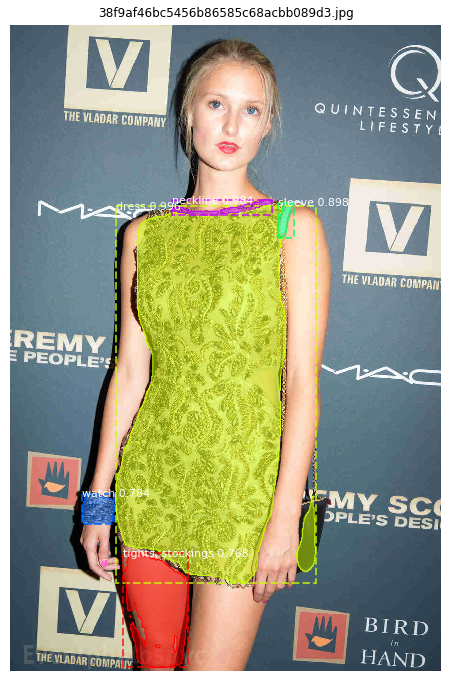

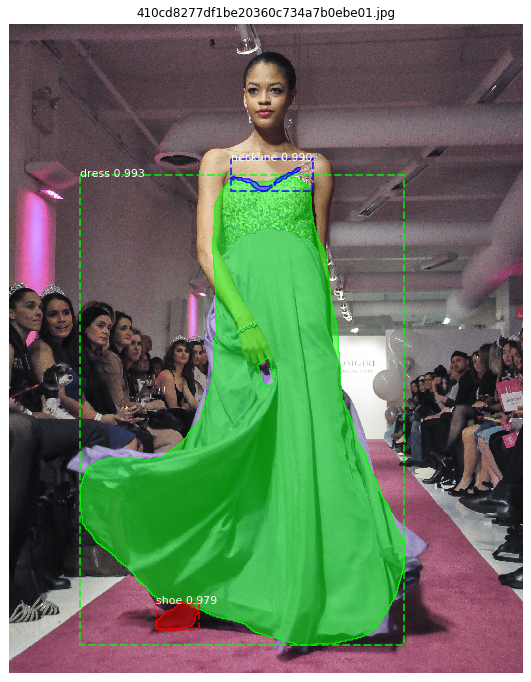

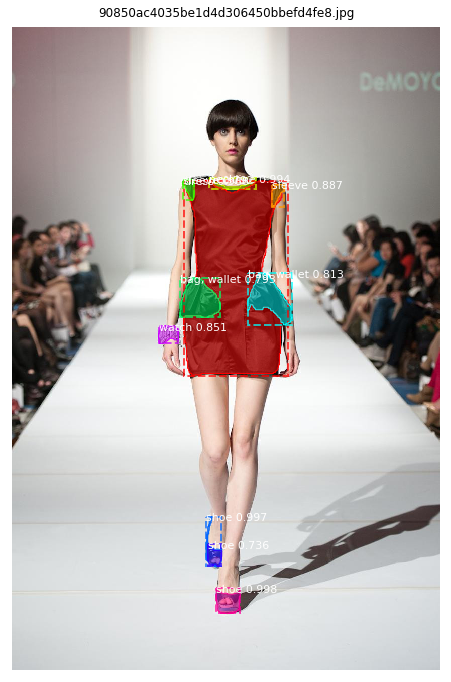

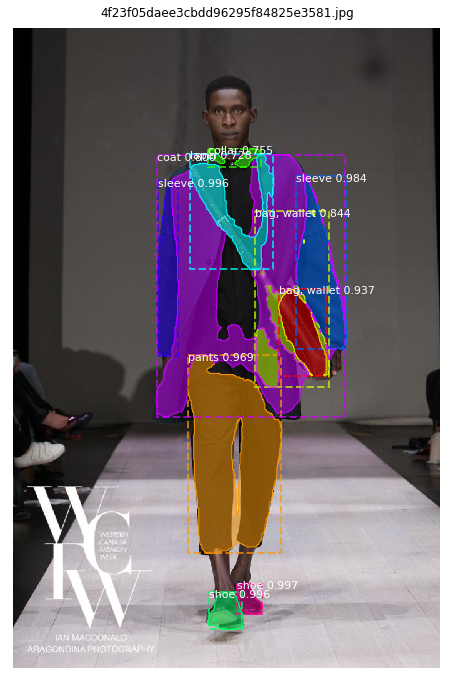

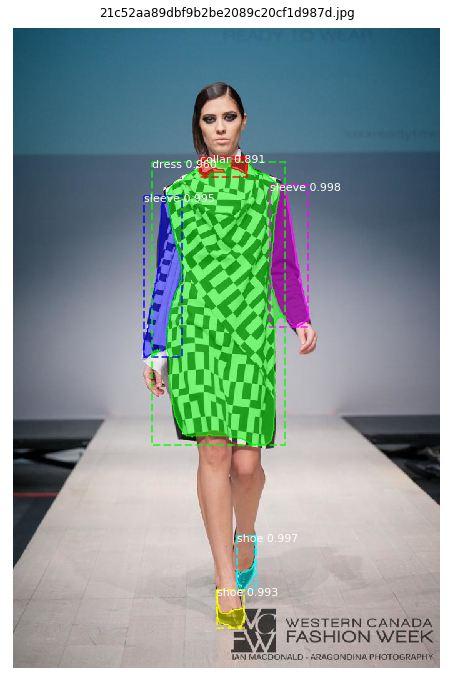

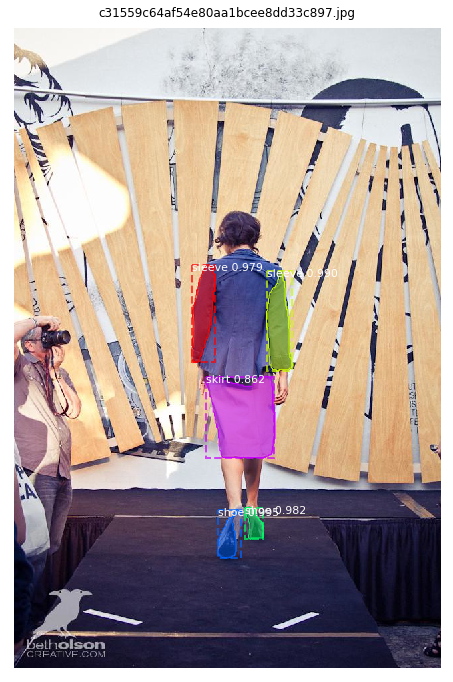

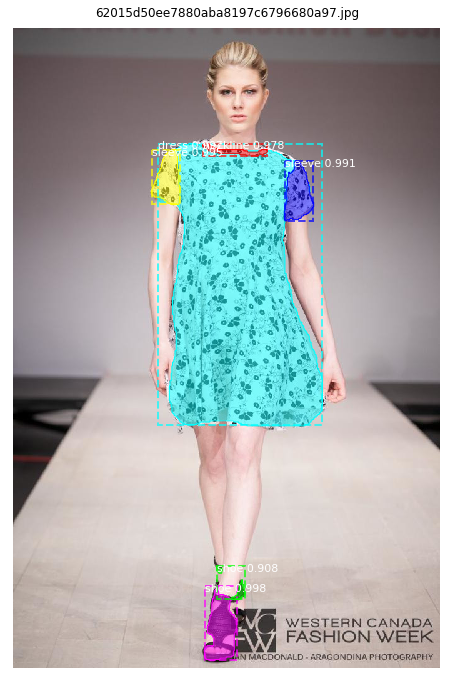

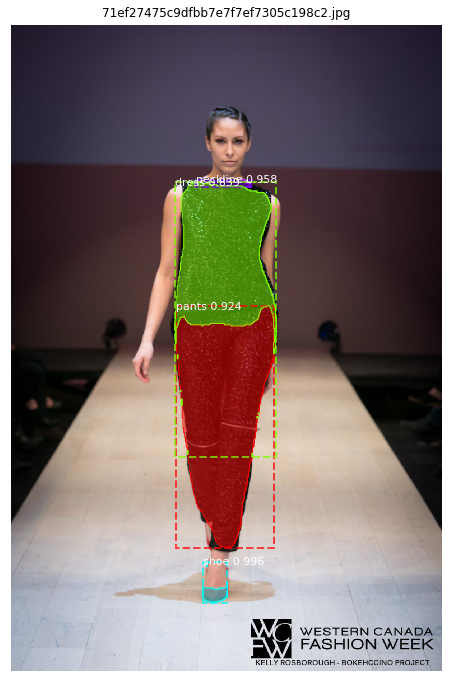

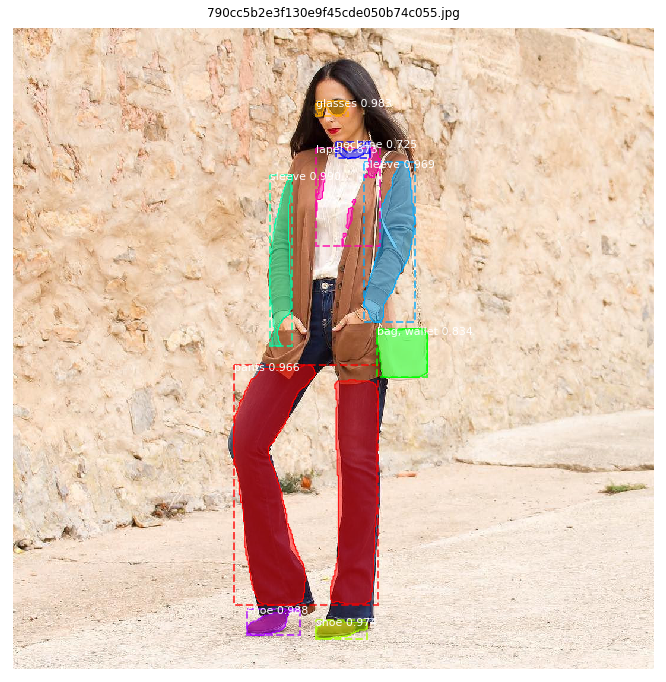

In [20]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(IMAGE_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

In [ ]:
# train all
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(IMAGE_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))